In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [131]:
prediction = pd.read_csv('/Users/qingpeng/TARA/predictions.out')

In [132]:
prediction_filtered = prediction[prediction.ID != 'ID']

In [133]:
len(prediction_filtered)

7734

In [134]:
len(prediction)

7737

In [135]:
prediction_filtered.dtypes

ID              object
Class           object
Class_id        object
Prob_class_0    object
Prob_class_1    object
Prob_class_2    object
Prob_class_3    object
dtype: object

In [77]:
len(result)

7737

### there are duplicates contigs id in different files

In [139]:
prediction_filtered.drop_duplicates(subset='ID', keep = 'first',inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [140]:
len(prediction_filtered)

7704

In [6]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

In [13]:
megan_annot = pd.read_csv('/Users/qingpeng/TARA/diamond-ex.txt',sep='\t',header=None,names=['ID','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)

In [130]:
megan_annot.dtypes

ID           object
tax_id        int64
rank         object
tax_name     object
top_label    object
dtype: object

In [16]:
megan_annot.head()

,ID,tax_id,rank,tax_name,top_label
0,k119_181893,1,no rank,root,N/A
1,k119_203060,1,no rank,root,N/A
2,k119_451532,1,no rank,root,N/A
3,k119_738333,1,no rank,root,N/A
4,k119_105632,1,no rank,root,N/A


In [32]:
len(megan_annot)

6314

In [64]:
megan_annot.drop_duplicates(subset='ID', keep = 'first',inplace=True)

In [65]:
len(megan_annot)

6306

In [141]:
new_table = pd.merge(prediction_filtered,megan_annot,how='left',on='ID')

In [142]:
len(new_table)

7704

In [144]:
new_table['top_label'].fillna('N/A',inplace = True)

### 7704 contigs with length >=3k, in TARA, with prediction


In [163]:
new_table.Prob_class_1 = pd.to_numeric(new_table.Prob_class_1)

### 3565 Contigs with prediction score >0.95

In [169]:
len(new_table[new_table.Prob_class_1>0.95])

3565

### Out of them, 18 are annotated as "Virus" by MEGAN with BlastX/Diamond to Nr database

and 

- 51 Bacteria
- 2950 Eukaryota
- 546 Unknown (no significant Blastx hits)

In [180]:
new_table[new_table.Prob_class_1>0.95].groupby('top_label').size()

top_label
Bacteria       51
Eukaryota    2950
N/A           546
Virus          18
dtype: int64

### If we look at the whole 7704 >3k contigs, most of the contigs are annotated by MEGAN as "Eukaryota"



In [181]:
new_table.groupby('top_label').size()

top_label
Bacteria       83
Eukaryota    6080
N/A          1520
Virus          21
dtype: int64

### 21 Contigs are annotated as "Virus" by MEGAN with BlastX/Diamond to Nr database

In [167]:
new_table[new_table.top_label=='Virus']

,ID,Class,Class_id,Prob_class_0,Prob_class_1,Prob_class_2,Prob_class_3,tax_id,rank,tax_name,top_label
3898,k119_427485,1,1,0.00155768,0.985145,0.00357599,0.00972103,1685757.0,species,Lake Sarah-associated circular virus-3,Virus
4179,k119_501378,1,1,0.000329087,0.994675,0.00138107,0.00361492,1888314.0,species,Baker virus,Virus
4512,k119_589941,1,1,9.74226e-06,0.999732,5.13105e-05,0.000207139,10501.0,family,Phycodnaviridae,Virus
4862,k119_686241,1,1,5.72815e-05,0.998561,0.000282935,0.0010985,35278.0,no rank,"ssRNA positive-strand viruses, no DNA stage",Virus
4950,k119_708605,1,1,0.00257979,0.953642,0.0294936,0.0142846,1804154.0,species,Marine RNA virus PAL156,Virus
5022,k119_726465,1,1,0.000829112,0.989041,0.00401403,0.00611634,10239.0,superkingdom,Viruses,Virus
5443,k119_837204,1,1,0.0186616,0.802792,0.122644,0.0559021,10239.0,superkingdom,Viruses,Virus
5770,k119_920342,1,1,0.00795523,0.909264,0.0312768,0.0515039,35342.0,no rank,unclassified ssDNA viruses,Virus
5827,k119_932436,1,1,0.0180134,0.776970,0.159436,0.04558,10501.0,family,Phycodnaviridae,Virus
5955,k119_968120,1,1,0.000227351,0.996487,0.00135903,0.00192703,10239.0,superkingdom,Viruses,Virus


In [148]:
df_virus = new_table[new_table.top_label=='Virus']

In [149]:
df_Eukaryota = new_table[new_table.top_label=='Eukaryota']
df_Bacteria = new_table[new_table.top_label=='Bacteria']
df_NA = new_table[new_table.top_label=='N/A']


### Prediction score distribution of all the 7704 Contigs

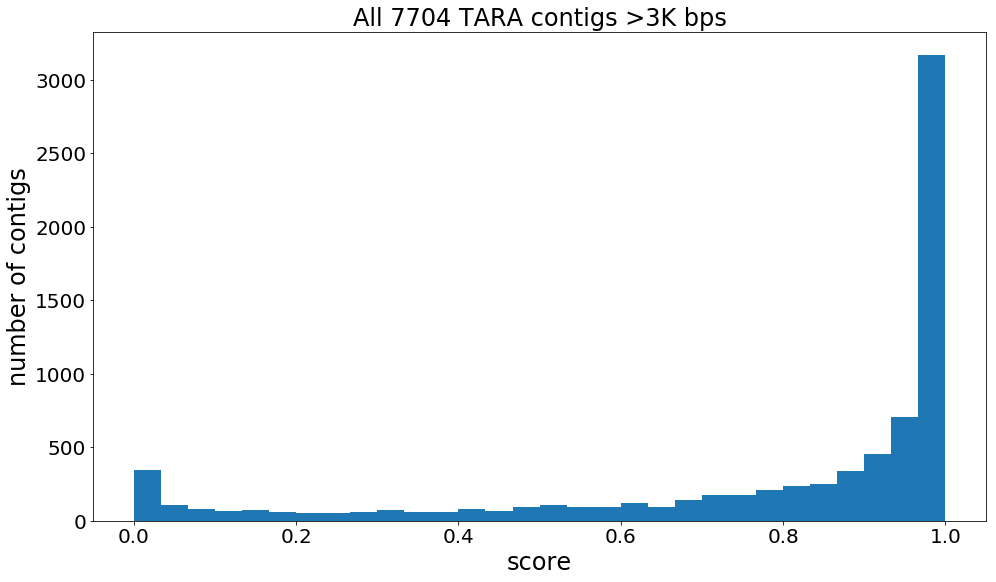

In [155]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(new_table.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('All 7704 TARA contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

### Prediction score distribution of the contigs annotated as "Virus", "Eukaryota", "Bacteria", "Unknown" by MEGAN/Blastx

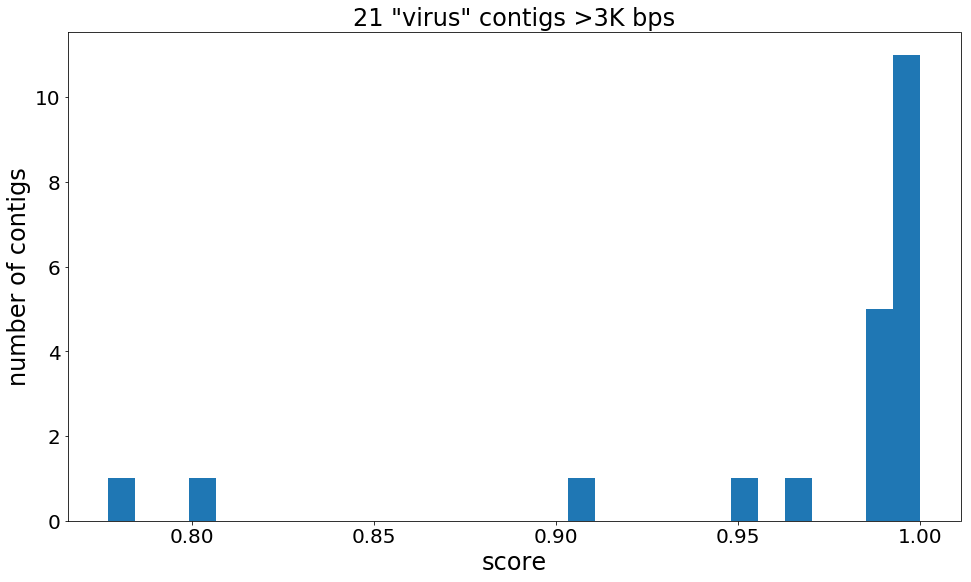

In [157]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_virus.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('21 \"virus\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

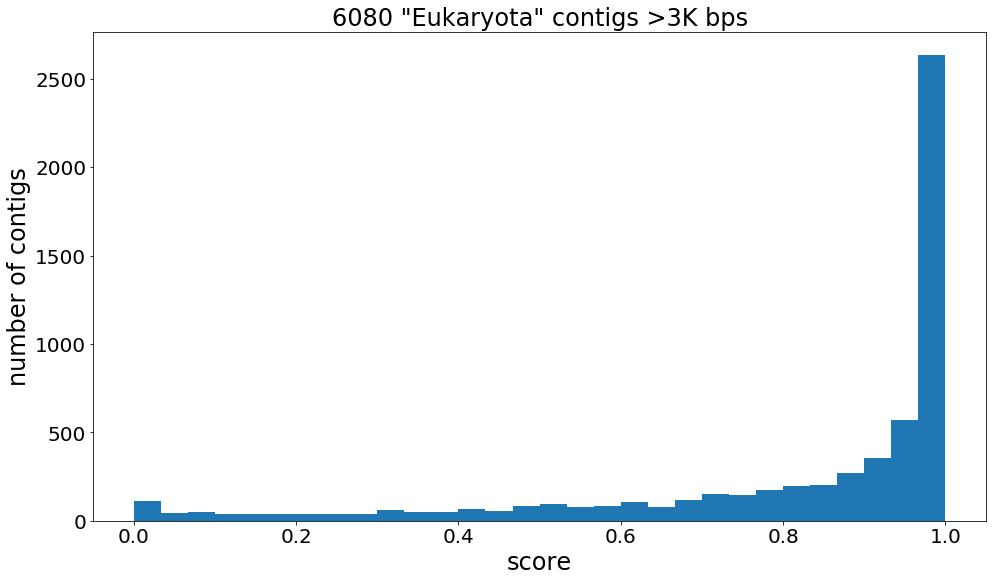

In [158]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_Eukaryota.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('6080 \"Eukaryota\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

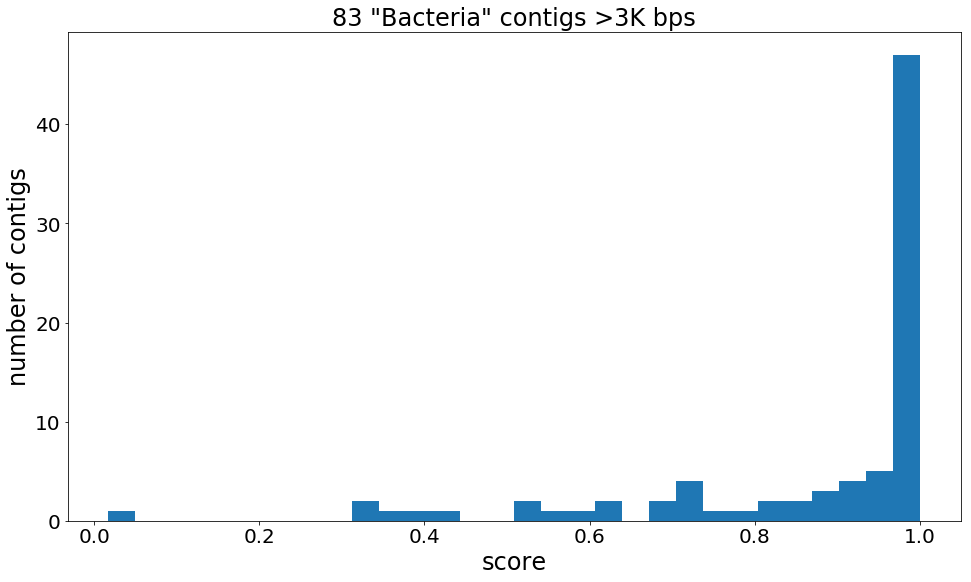

In [159]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_Bacteria.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('83 \"Bacteria\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)

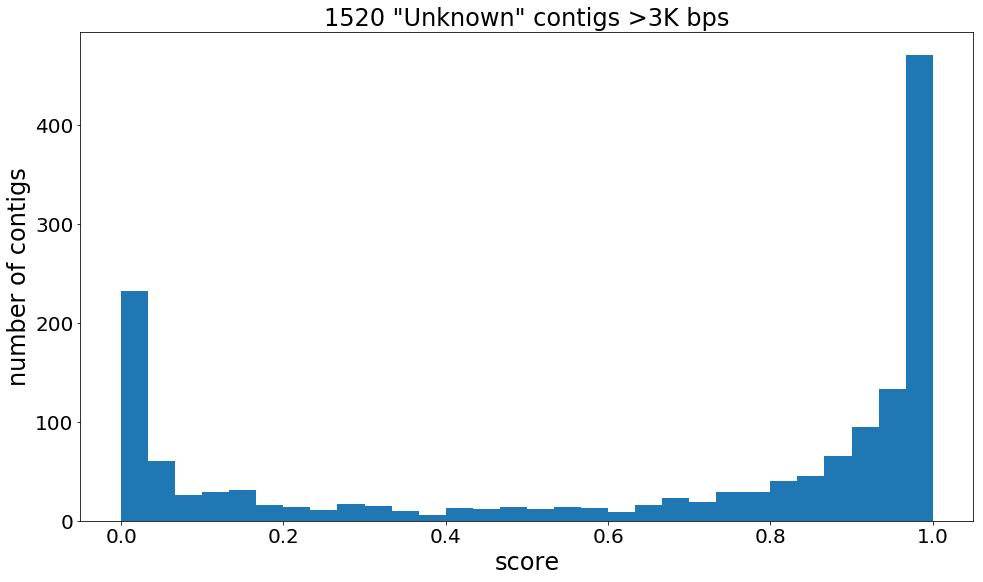

In [160]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [pd.to_numeric(df_NA.Prob_class_1)]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus'])
ax0.set_title('1520 \"Unknown\" contigs >3K bps',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)